# Assessing the ICON-ModEx ML models

## How does the model score change with each ICON-ModEx iteration?
This notebook will harvest the data from the `dynamic-learning-rivers` repository to make a plot showing the evolution of the ML models as more traininig data is added.

## Important behind the scenes information
Here, I am assuming that this notebook is running in a Linux context (e.g. pull a [container that runs a local Jupyter server](https://hub.docker.com/r/jupyter/datascience-notebook) and open the notebook therein). This code will switch branches within a repository that it downloads from GitHub to load the data for side by side comparisions. It will then delete the source repository and retain only the harvested data used for plotting. The harvested data will be saved alongside this notebook here.

## Jumping between Python and R
Working between these two languages can be done cell-by-cell (i.e. `r2py`) or, in this case, notebook by notebook by launching additional "subnotebooks" with `papermill`. We use the latter option here because we want a Python loop to launch a series of R tasks; this is harder to do when all the R must be in a separate cell from the Python.

When installing R tidyverse into the conda environment, there are at least three options:
1. Direct install from CRAN, e.g.:
```
install.packages("tidyverse", repos='http://cran.us.r-project.org', quiet=FALSE, Ncpu=4)
```
2. Conda install from conda-forge:
```
conda install -c conda-forge r-tidyverse
```
3. Conda install from anaconda:
```
conda install -c anaconda r-tidyverse
```
As of July 2024, there are linking (not compile) errors for some of the dependencies in Option 1. Option 1, since it compiles from source, also takes a relatively long time (10's of minutes). Option 2 seemed like the best way to go since thre are many more downloads of those packages than Option 3, but there are some bugs in how the figure domain is set up and communicated to Jupyter thus impacting some plotting routines. Therefore, Option 3 is the only one that worked end-to-end. It could be that the exact version of Python and/or Jupyter that I am using conflicts with Option 2. The hashes differ on some, but not all, of the R packages installed in Options 2 and 3 (i.e. comparing them with `conda list | grep r-`).

In [1]:
# Run once at start of notebook if these 
# packages are not already installed
! conda install -y -q pandas numpy matplotlib
! conda install -y -q papermill
! conda install -y -q scikit-learn

# Packages needed for R notebook
# Conda install pulls binaries from conda-forge, much faster than
# installing direct from CRAN (and building from source).
# ALso, some packages have linking errors when building 
# from source.

# Install packages from Conda Forge (Option 2, above)
#! conda install -y -q -c conda-forge r-tidyverse
#! conda install -y -q -c conda-forge r-colourpicker
#! conda install -y -q -c conda-forge r-emmeans
#! conda install -y -q -c conda-forge r-ggspatial
#! conda install -y -q -c conda-forge r-spdata
#! conda install -y -q -c conda-forge r-ggpmisc
#! conda install -y -q -c conda-forge r-ggextra
#! conda install -y -q -c conda-forge r-patchwork

# Install packages from Anaconda (Option 3, above)
! conda install -y -q -c anaconda r-tidyverse
! conda install -y -q -c anaconda r-ggextra

# Convert from .Rmd. Not used
#! conda install -y -q jupytext

# Get an environment definition file for reproducibility
# (i.e. you can rebuild this environment with `conda env update --name <env_name> -f icon-modex-scatter-plot-conda-env.yaml`
! conda env export > icon-modex-scatter-plot-conda-env.yaml

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/sfgary/pw/.miniconda3c

  added / updated specs:
    - matplotlib
    - numpy
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bottleneck-1.3.7           |  py311hf4808d0_0         145 KB
    brotli-1.0.9               |       h5eee18b_8          18 KB
    brotli-bin-1.0.9           |       h5eee18b_8          19 KB
    contourpy-1.2.0            |  py311hdb19cb5_0         263 KB
    cycler-0.11.0              |     pyhd3eb1b0_0          12 KB
    cyrus-sasl-2.1.28          |       h52b45da_1         237 KB
    dbus-1.13.18               |       hb2f20db_0         504 KB
    fonttools-4.51.0           |  py311h5eee18b_0         3.0 MB
    gst-plugins-base-1.14.1    |       h6a678d5_1         2.2 MB
    gstreamer-1.14.1           

In [32]:
import pandas as pd
import numpy as np
import papermill as pm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Convert .Rmd subscript to .ipynb
#! jupytext --to notebook make_scatter_plot.Rmd

## Clone source repository

In [2]:
repo_prefix = '~/tmp/'
repo_org='parallelworks'
repo_name='dynamic-learning-rivers'
repo_url = 'https://github.com/'+repo_org+'/'+repo_name

! mkdir -p {repo_prefix}
! cd {repo_prefix}; git clone {repo_url}

fatal: destination path 'dynamic-learning-rivers' already exists and is not an empty directory.


## Grab data and save to CSV
Here we want to track the model score over ModEx iterations.

In [49]:
# Functionalize all the data preporatory steps based on the
# branch name.
def prep_data_on_branch(repo_prefix=repo_prefix, repo_name=repo_name, branch_name='main', target_name='Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'):

    # Change to the requested branch
    ! cd {repo_prefix}/{repo_name}; git checkout {branch_name}
    
    # Create a working directory for this branch
    ! mkdir -p ./intermediate_branch_data/{branch_name}
    
    # Load data we want to prepare/merge/preprocess
    data_prefix=repo_prefix+'/'+repo_name
    main_input = pd.read_csv(data_prefix+"/scripts/prep_01_output_train.csv")
    avg_output = pd.read_csv(data_prefix+'/scripts/post_01_output_ml_predict_avg.csv')
    std_output = pd.read_csv(data_prefix+'/scripts/post_01_output_ml_predict_std.csv')
    
    # Use Sample_ID as the index so files can be merged on this value
    main_input.set_index('Sample_ID',inplace=True)
    avg_output.set_index('Sample_ID',inplace=True)
    std_output.set_index('Sample_ID',inplace=True)

    # Merge files
    avg_merge = pd.merge(
        main_input,
        avg_output, 
        left_index=True,
        right_index=True,
        suffixes=['_obs','_pre_avg'])
    
    # Add log calculations for use with R notebook
    avg_merge['Log_Observed_Normalized_Respiration_Rate'] = np.log10(np.abs(avg_merge[target_name+'_obs']))
    avg_merge['Log_Predicted_Normalized_Respiration_Rate'] = np.log10(np.abs(avg_merge[target_name+'_pre_avg']))
    
    all_merge = pd.merge(
        avg_merge,
        std_output, 
        left_index=True,
        right_index=True,
        suffixes=['','_pre_std'])

    predict_and_obs_merge = pd.merge(
        avg_output,
        std_output,
        left_index=True,
        right_index=True,
        suffixes=['_pre_avg','_pre_std'])
    
    # Write intermediate output files
    # Name it the same as what the R notebook expects...
    avg_merge.to_csv('intermediate_branch_data/'+branch_name+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv',mode='w')
    all_merge.to_csv('intermediate_branch_data/'+branch_name+'/output_obs_avgpre_stdpre_merged.csv',mode='w')
    predict_and_obs_merge.to_csv('intermediate_branch_data/'+branch_name+'/output_all_sites_avgpre_stdpre_merged.csv',mode='w')


In [60]:
# Start from fresh! Delete any .csv files that may already be here
!rm -f ICON-ModEx_automated_iterations.csv

# Define the threshold for strong/weak respiration rates
respiration_threshold = -500.0 

# List the branches we want to work with
list_branches_scale = [
    'Dec-2021',
    'Jul-2022',
    'Aug-2022',
    'Sep-2022',
    'Oct-2022',
    'Nov-2022',
    'Dec-2022',
    'Jan-2023',
    'Feb-2023',
    'Mar-2023',
    'ICON-ModEx-v2.1-April-2023-replicate-01',
    'ICON-ModEx-v2.1-April-2023-replicate-02',
    'May-2023',
    'June-2023',
    'Jul-2023',
    'August-2023',
    'Sep-2023',
    'Oct-2023',
    'Nov-2023']

list_branches_log10 = [
    'Dec-2021-log10',
    'Sep-2019-log10',
    'Jul-2022-log10',
    'Aug-2022-log10',
    'Sep-2022-log10',
    'Oct-2022-log10',
    'Nov-2022-log10',
    'Dec-2022-log10',
    'Jan-2023-log10',
    'Feb-2023-log10',
    'Mar-2023-log10',
    'Apr-2023-log10',
    'May-2023-log10',
    'June-2023-log10',
    'Jul-2023-log10',
    'August-2023-log10',
    'Sep-2023-log10',
    'Oct-2023-log10',
    'Nov-2023-log10',
    'Nov-2023-log10-DO-update-correct']

# Initialize empty dataframes
icon_modex_log10 = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain','roc-auc'])
icon_modex_scale = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain','roc-auc'])

#=======================================
# Gather data over the standard branches
#=======================================
for bb,branch in enumerate(list_branches_scale):
    
    # Change to the requested branch
    # We do not need to prep_data_on_branch for the non-log10 branches
    # since we are not plotting the animation of the scatter. But,
    # we do need to do this step to generate the ROC-AUC anyway.
    if branch in ['Dec-2021']:
        prep_data_on_branch(
            repo_prefix=repo_prefix, 
            repo_name=repo_name, 
            branch_name=branch, target_name='Respiration_Rate_mg_DO_per_L_per_H')
    elif branch in ['June-2023','Jul-2023','August-2023','Sep-2023','Oct-2023','Nov-2023']:
        prep_data_on_branch(
            repo_prefix=repo_prefix,
            repo_name=repo_name,
            branch_name=branch, target_name='Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment')
    else:
        # Different target name for all other branches
        prep_data_on_branch(
            repo_prefix=repo_prefix, 
            repo_name=repo_name, 
            branch_name=branch, target_name='Respiration_Rate_mg_per_L_per_H')
    #!cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # We want to get the mean and std of the score and plot that vs the number of inputs to train.
    # Each dot will be an ICON-ModEx iteration.
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+'/'+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    # Some of these points are dropped during training due to
    # missing values. A better measure of the actual number of
    # data points used to train the models is in the 
    # alternative file which is present after all the 
    # preprocessing steps are completed.
    # RAW INPUT
    #input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    # PREPROCESSED INPUT
    input_data = pd.read_csv(repo_prefix+'/'+repo_name+'/scripts/prep_06_output_final_train.csv')
    
    # Gather data and force binary classification for ROC-AUC
    tmp_df = pd.read_csv('intermediate_branch_data/'+branch_name+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv')
    y_true = tmp_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'] > respiration_threshold
    y_score = tmp_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'] > respiration_threshold
    
    icon_modex_scale.loc[len(icon_modex_scale.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index),
        roc_auc_score(y_true,y_score)
    ]

#=====================================
# Gather data over the -log10 branches
#=====================================
for bb,branch in enumerate(list_branches_log10):
    
    # Change to the requested branch
    prep_data_on_branch(repo_prefix=repo_prefix, repo_name=repo_name, branch_name=branch)
    #!cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # We want to get the mean and std of the score and plot that vs the number of inputs to train.
    # Each dot will be an ICON-ModEx iteration.
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+'/'+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    # RAW INPUT (see note above)
    #input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    # PREPROCESSED INPUT
    input_data = pd.read_csv(repo_prefix+'/'+repo_name+'/scripts/prep_06_output_final_train.csv')
    
    # Gather data and force binary classification for ROC-AUC
    tmp_df = pd.read_csv('intermediate_branch_data/'+branch_name+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv')
    y_true = tmp_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'] > respiration_threshold
    y_score = tmp_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'] > respiration_threshold
    
    icon_modex_log10.loc[len(icon_modex_log10.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index),
        roc_auc_score(y_true,y_score)
    ]
    
    # We could also grab the histogram of CONUS predictions to check for an evolution of bias over time
    # Grab code from the Figure-2 harvestor notebook if needed.
    # Use Papermill to launch a notebook
    # To list available kernels,
    #   jupyter kernelspec list
    # The working directory was created by prep_data_on_branch
    # The first R kernel execution takes a few extra minutes as
    # necessary R packages are installed on-the-fly during the 
    # first execution of the notebook (but subsequent reruns with
    # the same kernel do not need to reinstall).
    # Wrap this in try: except: because R-plotting raises an error
    # after the plot is made (probably a bounding box issue?)
    # that we can ignore.
    try:
        pm.execute_notebook(
            'make_scatter_plot.ipynb',
            'log_scatter_plot.ipynb',
            parameters=dict(work_dir='./intermediate_branch_data/'+branch),
            kernel_name='ir'
        )
    except:
        print('Caught error in notebook. Keep going...')

Switched to branch 'Dec-2021'
Your branch is up to date with 'origin/Dec-2021'.
Switched to branch 'Jul-2022'
Your branch is up to date with 'origin/Jul-2022'.
Updating files: 100% (185/185), done.
Switched to branch 'Aug-2022'
Your branch is up to date with 'origin/Aug-2022'.
Updating files: 100% (185/185), done.
Switched to branch 'Sep-2022'
Your branch is up to date with 'origin/Sep-2022'.
Updating files: 100% (185/185), done.
Switched to branch 'Oct-2022'
Your branch is up to date with 'origin/Oct-2022'.
Switched to branch 'Nov-2022'
Your branch is up to date with 'origin/Nov-2022'.
Switched to branch 'Dec-2022'
Your branch is up to date with 'origin/Dec-2022'.
Updating files: 100% (185/185), done.
Switched to branch 'Jan-2023'
Your branch is up to date with 'origin/Jan-2023'.
Switched to branch 'Feb-2023'
Your branch is up to date with 'origin/Feb-2023'.
Updating files: 100% (185/185), done.
Switched to branch 'Mar-2023'
Your branch is up to date with 'origin/Mar-2023'.
Switched t

Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (327/327), done.
Switched to branch 'Sep-2019-log10'
Your branch is up to date with 'origin/Sep-2019-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (344/344), done.
Switched to branch 'Jul-2022-log10'
Your branch is up to date with 'origin/Jul-2022-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Switched to branch 'Aug-2022-log10'
Your branch is up to date with 'origin/Aug-2022-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Sep-2022-log10'
Your branch is up to date with 'origin/Sep-2022-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Oct-2022-log10'
Your branch is up to date with 'origin/Oct-2022-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Nov-2022-log10'
Your branch is up to date with 'origin/Nov-2022-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Switched to branch 'Dec-2022-log10'
Your branch is up to date with 'origin/Dec-2022-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Switched to branch 'Jan-2023-log10'
Your branch is up to date with 'origin/Jan-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Feb-2023-log10'
Your branch is up to date with 'origin/Feb-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Mar-2023-log10'
Your branch is up to date with 'origin/Mar-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Apr-2023-log10'
Your branch is up to date with 'origin/Apr-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Switched to branch 'May-2023-log10'
Your branch is up to date with 'origin/May-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Switched to branch 'June-2023-log10'
Your branch is up to date with 'origin/June-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Jul-2023-log10'
Your branch is up to date with 'origin/Jul-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'August-2023-log10'
Your branch is up to date with 'origin/August-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Switched to branch 'Sep-2023-log10'
Your branch is up to date with 'origin/Sep-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
Switched to branch 'Oct-2023-log10'
Your branch is up to date with 'origin/Oct-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (356/356), done.
Switched to branch 'Nov-2023-log10'
Your branch is up to date with 'origin/Nov-2023-log10'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Switched to branch 'Nov-2023-log10-DO-update-correct'
Your branch is up to date with 'origin/Nov-2023-log10-DO-update-correct'.


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


In [61]:
# Example with high resolution images
#! convert -size 1080x1080 -delay 2 -loop 0 *.png output.gif

# Can't use wildcard this b/c lists files alphabetically (i.e. by month 
# name, not month order).
#! convert -delay 2 -loop 0 intermediate_branch_data/*/*.png scatter.gif

# Let's just manually prescribe the order since it's not that many 
# and there are some special cases. Make a temporary symbolic link
# to each file locally and name the links so that they go in the
# exact order of the ModEx iterations. Then, create the animation
# with convert and delete the symbolic links.
for bb,branch in enumerate(list_branches_log10):
    cc = bb + 100
    ! ln -sv intermediate_branch_data/{branch}/scatter.png ./tmp_{cc}.png
    
! convert -delay 100 -loop 0 tmp_*.png scatter.gif
! rm -f tmp_*.png

for bb,branch in enumerate(list_branches_log10):
    cc = bb + 100
    ! ln -sv intermediate_branch_data/{branch}/scatter_no_log.png ./tmp_{cc}.png
    
! convert -delay 100 -loop 0 tmp_*.png scatter_no_log.gif
! rm -f tmp_*.png

'./tmp_100.png' -> 'intermediate_branch_data/Dec-2021-log10/scatter.png'
'./tmp_101.png' -> 'intermediate_branch_data/Sep-2019-log10/scatter.png'
'./tmp_102.png' -> 'intermediate_branch_data/Jul-2022-log10/scatter.png'
'./tmp_103.png' -> 'intermediate_branch_data/Aug-2022-log10/scatter.png'
'./tmp_104.png' -> 'intermediate_branch_data/Sep-2022-log10/scatter.png'
'./tmp_105.png' -> 'intermediate_branch_data/Oct-2022-log10/scatter.png'
'./tmp_106.png' -> 'intermediate_branch_data/Nov-2022-log10/scatter.png'
'./tmp_107.png' -> 'intermediate_branch_data/Dec-2022-log10/scatter.png'
'./tmp_108.png' -> 'intermediate_branch_data/Jan-2023-log10/scatter.png'
'./tmp_109.png' -> 'intermediate_branch_data/Feb-2023-log10/scatter.png'
'./tmp_110.png' -> 'intermediate_branch_data/Mar-2023-log10/scatter.png'
'./tmp_111.png' -> 'intermediate_branch_data/Apr-2023-log10/scatter.png'
'./tmp_112.png' -> 'intermediate_branch_data/May-2023-log10/scatter.png'
'./tmp_113.png' -> 'intermediate_branch_data/June-2

# Load and plot data

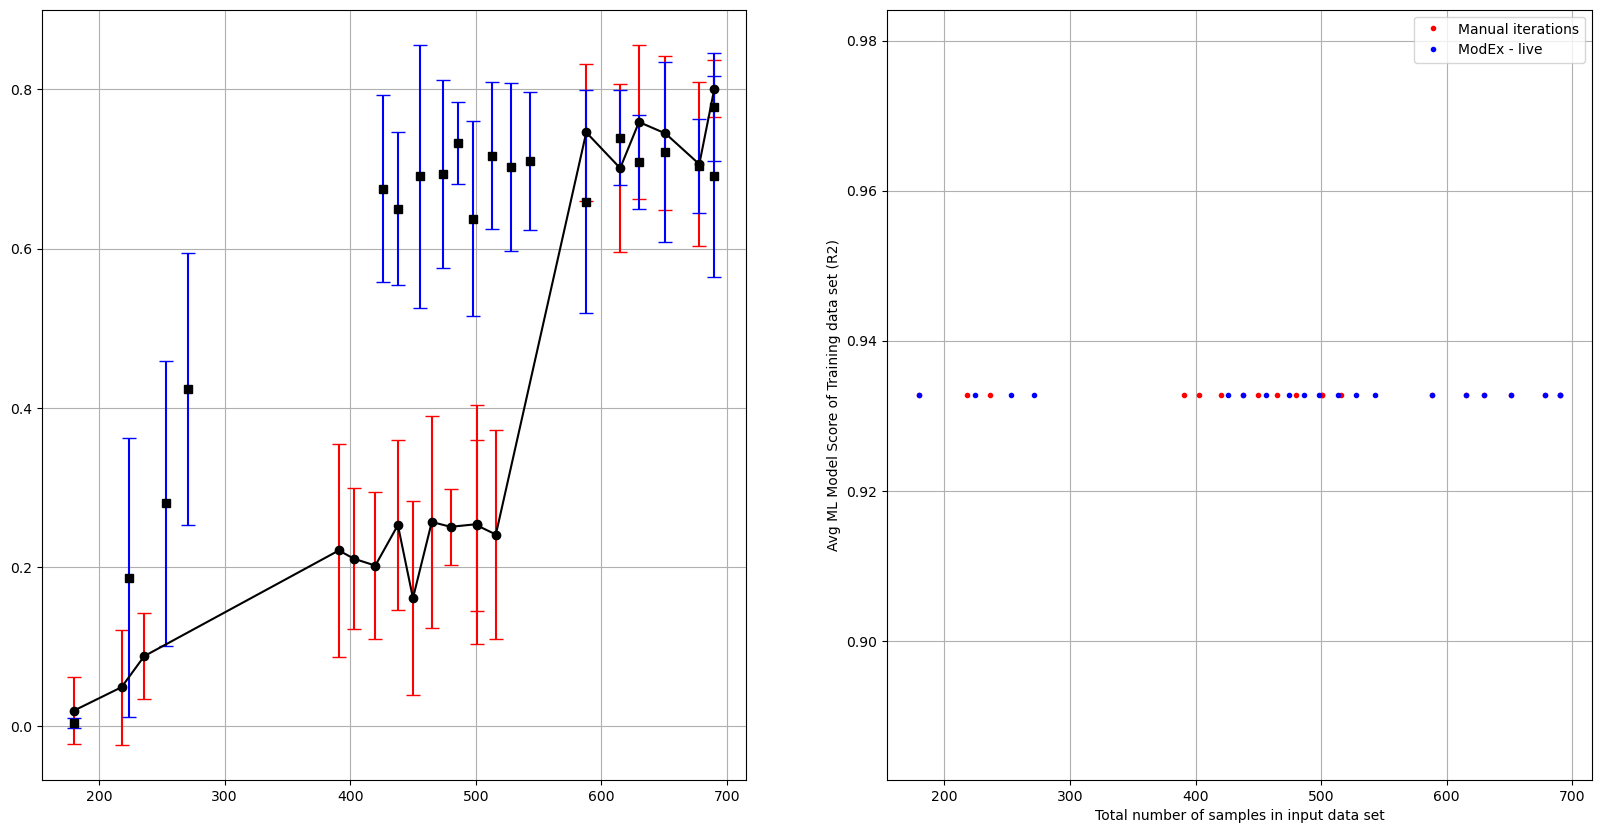

In [62]:
icon_modex_manual = pd.read_csv('ICON-ModEx_manual_iterations.csv')

# These iterations are the very first automated iterations
# presented at AGU2022. They were done in a "hindcast mode"
# to be able to compare to the manual iterations.
icon_modex_raw = pd.read_csv('ICON-ModEx_automated_iterations_raw.csv')

fig, [ax, ax2] = plt.subplots(1,2,figsize=(20,10))
# No need for manual iterations since recreated by workflow
#ax.errorbar(
#    icon_modex_manual['ntrain'],
#    icon_modex_manual[['hold-out','cv_avg']].max(axis=1),
#    yerr=icon_modex_manual['cv_std'],
#    fmt='k+',
#    ecolor='lightgray',
#    capsize=0)
#plt.errorbar(
#    icon_modex_raw['ntrain'],
#    icon_modex_raw['hold-out-avg'],
#    yerr=icon_modex_raw['hold-out-std'],
#    fmt='ko-',
#    ecolor='r',
#    capsize=5)
ax.errorbar(
    icon_modex_scale['ntrain'],
    icon_modex_scale['hold-out-avg'],
    icon_modex_scale['hold-out-std'],
    fmt='ko-',
    ecolor='r',
    capsize=5)
ax.errorbar(
    icon_modex_log10['ntrain'],
    icon_modex_log10['hold-out-avg'],
    icon_modex_log10['hold-out-std'],
    fmt='ks',
    ecolor='b',
    capsize=5)
ax.grid()

ax2.plot(
    icon_modex_scale['ntrain'],
    icon_modex_scale['roc-auc'],'r.')
ax2.plot(
    icon_modex_log10['ntrain'],
    icon_modex_log10['roc-auc'],'b.')
ax2.grid()

plt.ylabel('Avg ML Model Score of Training data set (R2)')
plt.xlabel('Total number of samples in input data set')
plt.legend(['Manual iterations','ModEx - live','ModEx - log10 hindcast'])
plt.savefig('ICON_ModEx_summary.pdf')

**Figure Caption:** Manual runs were done before AGU2022 as ICON-ModEx ramped up. The "live" iterations are the actual ICON-ModEx ML models that generated the results that were used for making decisions of which sites to sample. The hindcast iterations use a log10 filter because this reduces the bias of the ML models (see histogram analysis of Fig2). The big jump in the live iterations is due to the scaling of the respiration rate data with respect to the volume of the analysis container (need to double check this) (i.e. "Normalization") in June of 2023. The hindcast runs all take advantage of the scaling and the log10 transform to provide an apples-to-apples comparision of the progress of the ICON-ModEx iterations.

# Load and plot simplified version

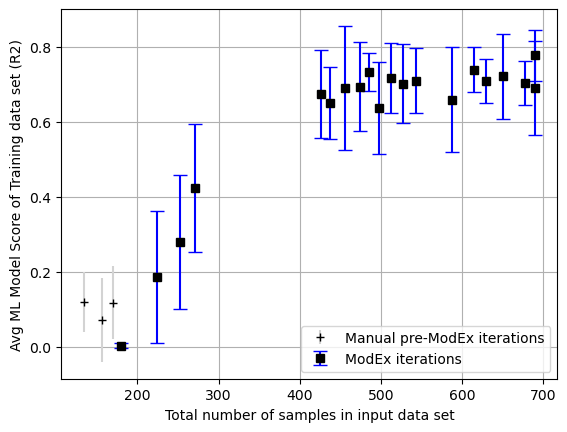

In [12]:
icon_modex_manual = pd.read_csv('ICON-ModEx_manual_iterations.csv')

# These iterations are the very first automated iterations
# presented at AGU2022. They were done in a "hindcast mode"
# to be able to compare to the manual iterations.
icon_modex_raw = pd.read_csv('ICON-ModEx_automated_iterations_raw.csv')

fig, ax = plt.subplots()
plt.errorbar(
    icon_modex_manual['ntrain'],
    icon_modex_manual[['hold-out','cv_avg']].max(axis=1),
    yerr=icon_modex_manual['cv_std'],
    fmt='k+',
    ecolor='lightgray',
    capsize=0)
plt.errorbar(
    icon_modex_log10['ntrain'],
    icon_modex_log10['hold-out-avg'],
    icon_modex_log10['hold-out-std'],
    fmt='ks',
    ecolor='b',
    capsize=5)
ax.grid()
plt.ylabel('Avg ML Model Score of Training data set (R2)')
plt.xlabel('Total number of samples in input data set')
plt.legend(['Manual pre-ModEx iterations','ModEx iterations'])
plt.savefig('ICON_ModEx_summary_simplified.pdf')

## Temporary experimentation with ROC AUC
1. The observations (`y`) must be 0 or 1 (i.e. perfect binary classifiers).
2. The predictions can be on a scale from 0 to 1 (i.e. confidence in each classification)
3. In our case, we want to know how well hot spots and cold spots are classified. Ideally, we would not force a threshold (i.e. 500 mg O2/L/hour) - but if we have to force a classification based on the observations, we would then need to figure out some kind of normalization of the predictions to go between 0 and 1. The choice of normalization is also arbitary, so there's no way to avoid some kind of arbitrary thresholding in this analysis.

In [31]:
# Generate some example data
a = [1, 0, 1, 0, 1]#, 5, 6, 5, 4]
b = a #[2, 1, 2, 0, 2, 7, 4, 6, 5]
metrics.roc_auc_score(a,b)
fpr, tpr, thresholds = metrics.roc_curve(a, b)

In [29]:
thresholds

array([inf,  1.,  0.])

In [17]:
b = [0, 1, 0, 1, 0]
metrics.roc_auc_score(a,b)

0.0

In [19]:
b = [1, 1, 1, 1, 1]
metrics.roc_auc_score(a,b)

0.5

In [40]:
a = [True, False, False, False]
b = [True, True, False, False]
metrics.roc_auc_score(a,b)

0.8333333333333334

In [38]:
thresholds

array([inf,  1.,  0.])

In [26]:
fpr

array([0. , 0. , 0.5, 0.5, 1. ])

In [27]:
tpr

array([0. , 0.5, 0.5, 1. , 1. ])

In [34]:
branch_name='Nov-2023-log10'
tmp_df = pd.read_csv('intermediate_branch_data/'+branch_name+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv')

In [41]:
tmp_df

,Sample_ID,Sample_Longitude_obs,Sample_Latitude_obs,Mean_Temp_Deg_C,pH,Mean_DO_mg_per_L,Mean_DO_percent_saturation,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs,Sample_Longitude_pre_avg,Sample_Latitude_pre_avg,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg,mean.error,predict.error,pca.dist,mean.error.scaled,pca.dist.scaled,combined.metric,Log_Observed_Normalized_Respiration_Rate,Log_Predicted_Normalized_Respiration_Rate
0,CM_001-1,-117.180494,46.732215,8.66,6.5,10.25,87.93,-41.53,-117.180494,46.732215,-201.733721,65.996270,845.909616,2.618854,0.196483,0.184700,0.036290,1.618362,2.304778
1,CM_001-2,-117.180494,46.732215,8.66,6.5,10.25,87.93,-47.82,-117.180494,46.732215,-201.733721,65.996270,845.909616,2.618854,0.196483,0.184700,0.036290,1.679610,2.304778
2,CM_001-3,-117.180494,46.732215,8.66,6.5,10.25,87.93,-42.31,-117.180494,46.732215,-201.733721,65.996270,845.909616,2.618854,0.196483,0.184700,0.036290,1.626443,2.304778
3,CM_002-1,-77.388447,38.781927,19.95,6.5,9.42,103.51,-83.28,-77.388447,38.781927,-155.999652,66.661657,845.961461,0.200349,0.198187,0.014130,0.002800,1.920541,2.193124
4,CM_002-2,-77.388447,38.781927,19.95,6.5,9.42,103.51,-173.76,-77.388447,38.781927,-155.999652,66.661657,845.961461,0.200349,0.198187,0.014130,0.002800,2.239950,2.193124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,S19S_0032-M,-119.023670,36.955030,13.10,7.0,9.35,87.50,-3.73,-119.023670,36.955030,-69.593400,69.072747,846.155292,8.195376,0.205047,0.577994,0.118516,0.571709,1.842568
683,S19S_0032-U,-119.023750,36.954970,13.10,7.0,9.35,87.50,-46.77,-119.023750,36.954970,-69.593400,69.072747,846.155292,8.195376,0.205047,0.577994,0.118516,1.669967,1.842568
684,S19S_0089-D,-80.445390,37.210080,20.80,7.0,9.95,118.60,-1185.05,-80.445390,37.210080,-510.756752,70.484424,846.312799,0.567333,0.214940,0.040012,0.008600,3.073737,2.708214
685,S19S_0089-M,-80.445290,37.210120,20.80,7.0,9.95,118.60,-1138.30,-80.445290,37.210120,-510.756752,70.484424,846.312799,0.567333,0.214940,0.040012,0.008600,3.056257,2.708214
